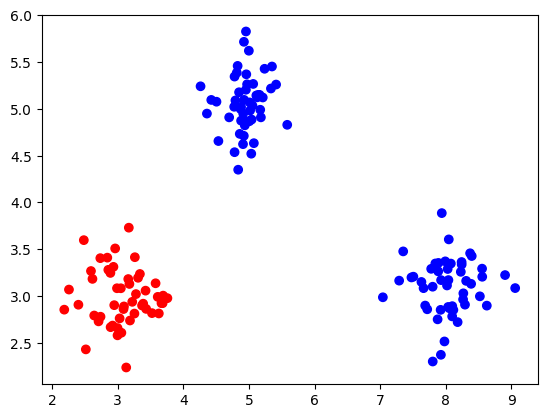

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg
from itertools import chain

import ipywidgets as widgets	
from IPython.display import display	

N1 = 50
N2 = 50
N3 = 50
K = 2
sigma = 0.1


mean = (3,3)
cov = [[sigma, 0], [0, sigma]]
X1 = np.random.multivariate_normal(mean, cov, N1)
c1 = [ 'red'] * len(X1)

mean = (5,5)
X2 = np.random.multivariate_normal(mean, cov, N2)
c2 = ['blue'] * len(X2)

mean = (8,3)
X3 = np.random.multivariate_normal(mean, cov, N3)
c3 = ['blue'] * len(X3)

X = np.concatenate( (X1, X2, X3) )
color = np.concatenate( (c1, c2, c3) )

T = np.zeros([len(X),1])
for n in range(0,len(X)):
    if(n < len(X1)) :
        T[n] = 0
    if(n >= N1 and n < len(X1) + len(X2) + len(X3)):
        T[n] = 1
        
T = T.astype (int)



plt.scatter(X[:, 0], X[:, 1], marker = 'o', c = color )
plt.show( )

In [5]:
M = 10
S = 3
alpha = 10
iters = 20 
N= len(X)

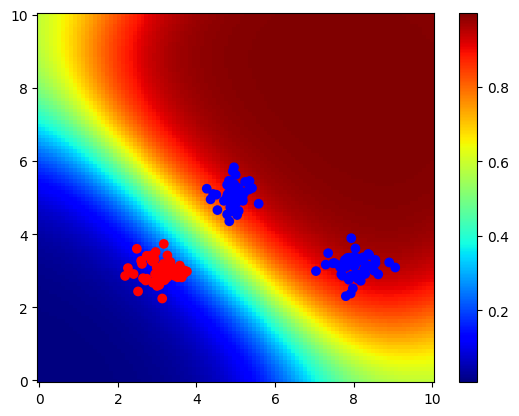

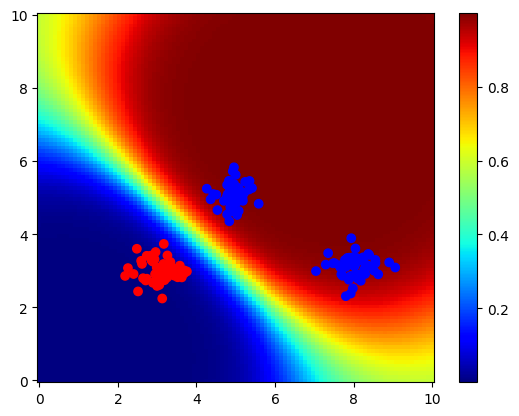

please enter X (comma separated):


Text(value='')

In [7]:
def sigmoid_basis(x, mu ,s):
    sigmoid = 1 / (1 + np.exp(-(x - mu) / s))
    return sigmoid

def guassian_basis_clf(x1, x2, mu, s):
    phi = np.exp(-1 * (((x1 - mu) ** 2) + ((x2 - mu) ** 2)) / (2 * (s ** 2)))  
    return phi

def predictive_clf_fitting(x, t, M, s, alpha1):
    
    x1 = X[:,0]
    x2 = X[:,1]
    N = len(x)
    phi = np.zeros([N,M])
    sig = np.zeros([N,1])
    w_map = np.zeros([M,1])
    R = np.zeros([N,N])
    H = np.zeros([M,M])

    # higher space
    for m in range(M):
        mu = m / M * 10 
        phi[:, m] = np.vectorize(guassian_basis_clf)(x1, x2, mu, s)

       
    iss0 = (1 / alpha1) * np.identity(M)      
         
    # newton
    for i in range(iters):
        
        for n in range(N):
            sig[n,:] = sigmoid_basis((w_map.T @ phi[n,:].T), 0, 1)
            
        Rnn = sig * (1 - sig)
        R = np.identity(N) * Rnn
        H = iss0 + (phi.T @ R @ phi)
        iH = linalg.solve(H, np.identity(M))
        # iH = linalg.inv(H)
        deltaE = ((iss0 @ (w_map - 0)) + phi.T @ (sig - t))
        w_map = w_map - ( iH @ deltaE )      #to do
        
    # ssn
    sig[:,0] = sigmoid_basis(np.dot(w_map.T, phi.T), 0, 1)
    Rnn_map = sig * (1 - sig)
    R_map = np.identity(N) * Rnn_map
    H_map = iss0 + phi.T @ R_map @ phi
    # H_map = phi.T @ R_map @ phi
    # ssn = linalg.inv(H_map)
    ssn = H_map
    
    # final
    return w_map, ssn
   
def predictive_clf_testing(x1, x2, M, s):
  
    phi_new = np.zeros([M,1])

    for m in range(M):
        mu = m / M * 10
        phi_new[m,:] = guassian_basis_clf(x1, x2, mu, s)
    

    a_map = np.dot(w_map1.T, phi_new)
    sigma = phi_new.T @ ssn1 @ phi_new

    tmp = a_map * ((1 + (np.pi / 8) * sigma ) ** (-0.5))

    p_dist = sigmoid_basis(tmp, 0, 1)
    
    return p_dist


nn = 100

[w_map1, ssn1] = predictive_clf_fitting(X, T, M, S, alpha)

#testing
side = np.linspace(0, 10, nn)
Xx,Yy = np.meshgrid(side, side)
Xx_c = list(chain(*Xx))
Yy_c = list(chain(*Yy))
testing = np.vectorize(predictive_clf_testing)
Zz = testing(Xx_c, Yy_c, M, S)







plt.figure(1)
cc = plt.pcolormesh(Xx, Yy, Zz.reshape(nn,nn), cmap='jet')
plt.scatter(X[:, 0], X[:, 1], marker = 'o', c = color )
plt.colorbar(cc)

plt.figure(2)
cc = plt.pcolormesh(Xx,Yy,pp_dist.reshape(nn,nn),cmap='jet')
plt.scatter(X[:, 0], X[:, 1], marker = 'o', c = color )
plt.colorbar(cc)

plt.show()

print("please enter X (comma separated):")
text = widgets.Text()
display(text)

def classify(sender):
    

    phi_new = np.zeros([M, 1])
    
    list = sender.value.split(",")
    x1 = float(list[0])
    x2 = float(list[1])
    
    for m in range(M):
        mu = m / M * 10
        phi_new[m, :] = guassian_basis_clf(x1, x2, mu, S)
    sigma = phi_new.T @ ssn1 @ phi_new
    
    result = predictive_clf_testing(x1, x2, M, S)

    if (result > 0.5):
        print("point ["+ sender.value +"] belongs to C2")
    else:
        print("point ["+ sender.value +"] belongs to C1")
    
    print("uncertainty information:"+str(sigma))
            
    
text.on_submit(classify)
